In [362]:
using Optics_in_the_length_gauge
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful
using Statistics
using Optics_in_the_length_gauge
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful
using Statistics
using StaticArrays
using Parameters
using CairoMakie
using LaTeXStrings
using LMC
using JLD2
# add https://github.com/fernandopenaranda/Optics_in_the_length_gauge
# units meV, fs, K
const kB = (PhysicalConstants.CODATA2018.k_B |> u"eV/K").val
const μB = (PhysicalConstants.CODATA2018.BohrMagneton |> u"eV/T").val
const ħ = PhysicalConstants.CODATA2018.ħ
const e = PhysicalConstants.CODATA2018.e
const C = ((e^3 / ħ^2) |> u"μA/V^2/s").val
const C_cd = ((e^2/ħ) |> u"μA/V").val
const ħ_ev_s = (ħ |> u"eV*s").val
const ang_to_m = 1e-10
const Kb_in_mev = 1e3* kB


proj_folder = dirname(pwd())
rhomb_folder = proj_folder * "/model/rhombohedral/"
common_folder = proj_folder * "/comfunctions/"
figures_folder = proj_folder * "/Paper/Figures/"

"/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/Figures/"

## Presets

In [95]:
#presets
μlist = collect(0:1:15)
p = Params_rhombohedral(1, 0, 3160, 390,-20, 315, 0*44, 2, 0)
B = 10
evals =50000#200000 #evals 80000 not perfect
T = 0.1 # T = 0.1, evals = 500000 quite good for drude conductivities
τ = 200 # not appearing
Nlist = [3,4,5,6,7]

xx_drude_presets(N, μ,ξ, evals) = 
    xx_drude_presets(N, μ, ξ, p; evals = evals, T = T, τ = τ)
lmcnoshift_presets(N, μ, ξ, evals) = xxx_lmc_presets(N, μ, ξ, p; evals = evals,
    T = T, τ = τ, berry_contribution = true, omm_contribution = true, 
    fermi_surface = false, with_shift = false)

lmcnoshift_presets (generic function with 1 method)

## Plotting functions

In [365]:
function lat_figure_berry(N, μlist, ξ, p, T; kpoints = 100)
    with_theme(merge(theme_latexfonts(), Theme(fontsize = fontsizetheme))) do #
        figure_berry(N, μlist, ξ, p, T; kpoints = kpoints)     
    end
end

function figure_berry(N, μlist, ξ, p, T; kpoints = 100, colrange = [-1,1])
    fig = Figure()
    prefactor = maximum(colrange)
    m2toang2 = 1e20
 
    

    colrange2 = colrange
    colmap = cgrad([:white, :black])

    
    axbands = Axis(fig[1,1:3], ylabel = L"$\text{E}\ \text{[meV]}$", title = "N = $(N)")
    LMC.abcNplotbandsk(axbands, N, kpoints, Params_rhombohedral(p, ξ =1); ylims = [-1, 1], color = :black)
    LMC.abcNplotbandsk(axbands, N, kpoints, Params_rhombohedral(p, ξ =-1); ylims = [-1, 1], color = :gray)
    
    ylims!(axbands, -0,8)
    axbands.yticks = [0, 4, 8]
    
    [hlines!(axbands, μ) for μ in μlist]
    
    
    #_________________________________________
    ga = fig[2:3, 1:3] = GridLayout()
    colrange_omegaz = [0,0.5]

    prefactor = 1e5
        
    lmcpresets1 = xxx_lmc_presets(N, μlist[1], ξ, p; T = T)
    lmcpresets2 = xxx_lmc_presets(N, μlist[2], ξ, p; T = T)
    lmcpresets3 = xxx_lmc_presets(N, μlist[3], ξ, p; T = T)


        kxs, kys, Z2s = kresolved_Ωz(p, lmcpresets1, points = kpoints) # Ωxy_fn
        Z2s .*= m2toang2 ./ prefactor
        kxs, kys, Z3s = kresolved_Ωz(p, lmcpresets2, points = kpoints) # Ωxy_fn
        Z3s .*= m2toang2 ./ prefactor
        kxs, kys, Z4s = kresolved_Ωz(p, lmcpresets3, points = kpoints) # Ωxy_fn
        Z4s .*= m2toang2 ./ prefactor
        
    
    ax2 = Axis(ga[1,1], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$")#, title = "|⟨Ωz⟩|")
    ax3 = Axis(ga[1,2], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$")
    ax4 = Axis(ga[1,3], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$")
    
    hmm = plotmap!(ax2, kxs, kys, abs.(Z2s), colrange = colrange_omegaz, colmap = colmap)
    hmm = plotmap!(ax3, kxs, kys, abs.(Z3s), colrange = colrange_omegaz, colmap = colmap)
    hmm = plotmap!(ax4, kxs, kys, abs.(Z4s), colrange = colrange_omegaz, colmap = colmap)

    ax2.xticks = [-0.1, 0, 0.1]
    ax2.yticks = [-0.1, 0, 0.1]

    
    #_________________________________________
    colrange_omegap = [0,1]


    pΩ_contr(μ) = xxx_lmc_presets(N, μ, ξ, p; T = T, berry_contribution = true, omm_contribution = false)
    pomm_contr(μ) = xxx_lmc_presets(N, μ, ξ, p; T = T, berry_contribution = false, omm_contribution = true)
    
        kxs, kys, Z5s = kresolved_Ωin(p, pΩ_contr(μlist[1]), points = kpoints) 
        kxs, kys, Z6s = kresolved_Ωin(p, pΩ_contr(μlist[2]), points = kpoints) 
        kxs, kys, Z7s = kresolved_Ωin(p, pΩ_contr(μlist[3]), points = kpoints) 
        Z5s .*= m2toang2 ./ prefactor
        Z6s .*= m2toang2 ./ prefactor
        Z7s .*= m2toang2 ./ prefactor
    
    ax5 = Axis(ga[2,1], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$")#, title = "|⟨Ω||⟩_FS|")
    ax6 = Axis(ga[2,2],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$")
    ax7 = Axis(ga[2,3],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$")
    
    ax5.xticks = [-0.1, 0, 0.1]
    ax5.yticks = [-0.1, 0, 0.1]
    ax6.xticks = [-0.1, 0, 0.1]
    ax7.xticks = [-0.1, 0, 0.1]



    hm5 = plotmap!(ax5, kxs, kys, abs.(Z5s), colrange = colrange_omegap, colmap = colmap)
    hm6 = plotmap!(ax6, kxs, kys, abs.(Z6s), colrange = colrange_omegap, colmap = colmap)
    hm7 = plotmap!(ax7, kxs, kys, abs.(Z7s), colrange = colrange_omegap, colmap = colmap)

    #_________________________________________
    
    
    # kxs, kys, Z6s = kresolved_dOMM(p, pomm_contr(μlist[1]), points = kpoints)
    # kxs, kys, Z7s = kresolved_dOMM(p, pomm_contr(μlist[2]), points = kpoints)
    
    # ax6 = Axis(fig[1,4], xlabel = "kx", ylabel = "ky")
    # ax7 = Axis(fig[2,4], xlabel = "kx", ylabel = "ky")

    # colrange_dm = [-1,1] .* 2 #[m, M]

    # hm6 = plotmap!(ax6, kxs, kys, Z6s, colrange = colrange_dm, colmap = colmap2)
    # hm7 = plotmap!(ax7, kxs, kys, Z7s, colrange = colrange_dm, colmap = colmap2)
    
    hidexdecorations!(ax2)
    hidexdecorations!(ax3)
    hidexdecorations!(ax4)
    hideydecorations!(ax3)
    hideydecorations!(ax4)
    hideydecorations!(ax6)
    hideydecorations!(ax7)
    
    Colorbar(fig[2,4], hmm, label = L"$\langle \Omega_z\rangle \times 10^5 [Å^2]$", ticks = [0, 0.5, 1])# "⟨Ωz⟩ [[×10^$(Int(log10(prefactor))) ]Å^2] ", ticks = [0, 0.5, 1])
    Colorbar(fig[3,4], hm5, label = L"$\langle \Omega_x\rangle_{\text{FS}} \times 10^5 [Å^2]$", ticks = [0, 0.5, 1])


    fig
end

figure_berry (generic function with 1 method)

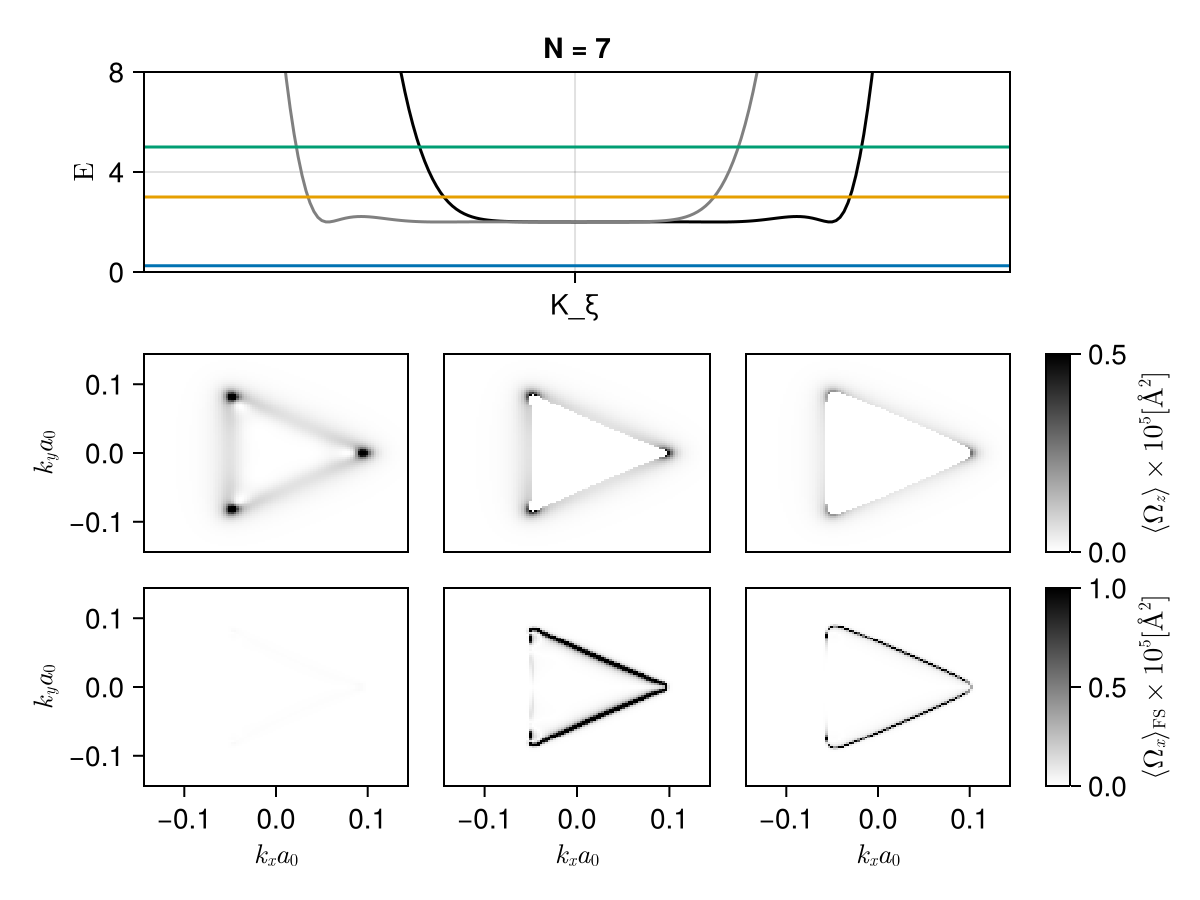

In [366]:
figure_berry(7, [0.25,3,5], 1, p, 0.1)